# 1. Setup

## 1-1. Library Setup

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from keras.utils import np_utils
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Input
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.metrics import AUC

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11569177842837944888
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16154099712
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16473423306838162705
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

In [3]:
!nvidia-smi

Sat Dec 18 04:57:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    33W / 250W |    375MiB / 16280MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


## 1-2. parameter setup

In [5]:
basemodel = 'DenseNet121'
image_size = 128
image_channels = 3
batch_size = 64
num_epochs = 100
class_num = 3
None_patience_num = 30
imagenet_patience_num = 20
S_all_labels = "S0", "S1", "S2"
T_all_labels = "T0", "T1", "T2"

#base_path = ''
base_path = 'gdrive/My Drive/Research_3_1_1/'

path_data = base_path + 'data_numpy/'
path_model_result = base_path + 'model_result/1 - Base_model_result/' + basemodel + '/'

In [6]:
S_model_name_imagenet = 'S_' + basemodel + '_imagenet'
S_model_name_None = 'S_' + basemodel + '_None'
T_model_name_imagenet = 'T_' + basemodel + '_imagenet'
T_model_name_None = 'T_' + basemodel + '_None'

print(S_model_name_None, S_model_name_imagenet, T_model_name_None, T_model_name_imagenet)

basemodel_list=[S_model_name_imagenet, S_model_name_None, T_model_name_imagenet, T_model_name_None]
basemodel_list

S_DenseNet121_None S_DenseNet121_imagenet T_DenseNet121_None T_DenseNet121_imagenet


['S_DenseNet121_imagenet',
 'S_DenseNet121_None',
 'T_DenseNet121_imagenet',
 'T_DenseNet121_None']

In [7]:
def createDirectory(name): 
    try: 
        if not os.path.exists(name): 
            os.makedirs(path_model_result + name) 
    except OSError: 
        print("Error: Failed to create the directory.")  
        
for i in basemodel_list:
    createDirectory(i)

# 2. Data Load and Image Check

## 2-1. Data Load

In [8]:
xTrain_S = np.load(path_data + 'xTrain_S.npy')
xValid_S = np.load(path_data + 'xValid_S.npy')
xTest_S = np.load(path_data + 'xTest_S.npy')

yTrain_S = np.load(path_data + 'yTrain_S.npy')
yValid_S = np.load(path_data + 'yValid_S.npy')
yTest_S = np.load(path_data + 'yTest_S.npy')

xTrain_T = np.load(path_data + 'xTrain_T.npy')
xValid_T = np.load(path_data + 'xValid_T.npy')
xTest_T = np.load(path_data + 'xTest_T.npy')

yTrain_T = np.load(path_data + 'yTrain_T.npy')
yValid_T = np.load(path_data + 'yValid_T.npy')
yTest_T = np.load(path_data + 'yTest_T.npy')

In [9]:
print(xTrain_S.shape, yTrain_S.shape)
print(xValid_S.shape, yValid_S.shape)
print(xTest_S.shape, yTest_S.shape)
print()
print(xTrain_T.shape, yTrain_T.shape)
print(xValid_T.shape, yValid_T.shape)
print(xTest_T.shape, yTest_T.shape)

(1920, 128, 128, 3) (1920, 1)
(640, 128, 128, 3) (640, 1)
(640, 128, 128, 3) (640, 1)

(1440, 128, 128, 3) (1440, 1)
(480, 128, 128, 3) (480, 1)
(480, 128, 128, 3) (480, 1)


In [10]:
xTrain_S = xTrain_S.astype('float32')/255
xValid_S = xValid_S.astype('float32')/255
xTest_S = xTest_S.astype('float32')/255

yTrain_S = np_utils.to_categorical(yTrain_S, class_num)
yValid_S = np_utils.to_categorical(yValid_S, class_num)
yTest_S = np_utils.to_categorical(yTest_S, class_num)

xTrain_T = xTrain_T.astype('float32')/255
xValid_T = xValid_T.astype('float32')/255
xTest_T = xTest_T.astype('float32')/255

yTrain_T = np_utils.to_categorical(yTrain_T, class_num)
yValid_T = np_utils.to_categorical(yValid_T, class_num)
yTest_T = np_utils.to_categorical(yTest_T, class_num)

In [11]:
print(xTrain_S.shape, yTrain_S.shape)
print(xValid_S.shape, yValid_S.shape)
print(xTest_S.shape, yTest_S.shape)
print()
print(xTrain_T.shape, yTrain_T.shape)
print(xValid_T.shape, yValid_T.shape)
print(xTest_T.shape, yTest_T.shape)

(1920, 128, 128, 3) (1920, 3)
(640, 128, 128, 3) (640, 3)
(640, 128, 128, 3) (640, 3)

(1440, 128, 128, 3) (1440, 3)
(480, 128, 128, 3) (480, 3)
(480, 128, 128, 3) (480, 3)


## 2-2. Image Check

xTrain_S image Numbers :  1920
xTrain_S image Numbers // 10 :  192
10


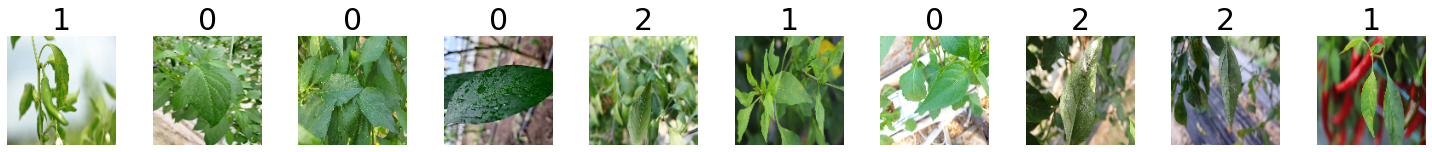

In [12]:
temp_S_a = len(xTrain_S)
print("xTrain_S image Numbers : ", temp_S_a)
temp_S_b = temp_S_a//10
print("xTrain_S image Numbers // 10 : ", temp_S_b)
temp_S_c = 0
for i in range(0, temp_S_a, temp_S_b):
    temp_S_c += 1
print(temp_S_c)


c=0
plt.figure(figsize=(20,3))
for i in range(0, temp_S_a, temp_S_b):
    plt.subplot(1, temp_S_c, c+1)
    plt.imshow(xTrain_S[i])
    plt.title(yTrain_S[i].argmax(),fontsize=30)
    plt.tight_layout()
    plt.axis('off')
    c+=1
plt.show()

xTrain_S image Numbers :  1440
xTrain_S image Numbers // 10 :  144
10


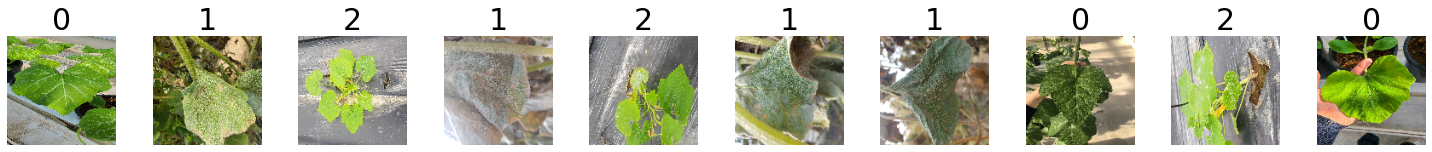

In [13]:
temp_T_a = len(xTrain_T)
print("xTrain_S image Numbers : ", temp_T_a)
temp_T_b = temp_T_a//10
print("xTrain_S image Numbers // 10 : ", temp_T_b)
temp_T_c = 0
for i in range(0, temp_T_a, temp_T_b):
    temp_T_c += 1
print(temp_T_c)


c=0
plt.figure(figsize=(20,3))
for i in range(0,temp_T_a,temp_T_b):
    plt.subplot(1, temp_T_c, c+1)
    plt.imshow(xTrain_T[i])
    plt.title(yTrain_T[i].argmax(),fontsize=30)
    plt.tight_layout()
    plt.axis('off')
    c+=1
plt.show()

# 3. Network Setting and Training

## 3-1. Network Setting

In [14]:
def feature_extractor_None(inp):
    base_model=tf.keras.applications.DenseNet121 (
                include_top=False, weights=None, input_tensor=inp)
    input = base_model.input
    out = base_model.layers[-1].output
    feature_output = tf.keras.layers.GlobalAveragePooling2D(name='feature')(out)
    return feature_output


def classifier_None(feature_output):
    out = feature_output
    out = Dense(128, activation="relu")(out)
    out = Dense(32, activation="relu")(out)
    classifier_output = Dense(class_num, activation="softmax", name="classifier_output")(out)
    return classifier_output


def model_None():
    inp = Input(shape=(image_size, image_size, image_channels))   
    feature_output = feature_extractor_None(inp)
    classifier_output = classifier_None(feature_output)
    model = Model(inputs=inp, outputs=classifier_output)
    return model

In [15]:
def feature_extractor_imagenet(inp):
    base_model=tf.keras.applications.DenseNet121 (
                include_top=False, weights='imagenet', input_tensor=inp)
    input = base_model.input
    out = base_model.layers[-1].output
    feature_output = tf.keras.layers.GlobalAveragePooling2D(name='feature')(out)
    return feature_output


def classifier_imagenet(feature_output):
    out = feature_output
    out = Dense(128, activation="relu")(out)
    out = Dense(32, activation="relu")(out)
    classifier_output = Dense(class_num, activation="softmax", name="classifier_output")(out)
    return classifier_output


def model_imagenet():
    inp = Input(shape=(image_size, image_size, image_channels))   
    feature_output = feature_extractor_imagenet(inp)
    classifier_output = classifier_imagenet(feature_output)
    model = Model(inputs=inp, outputs=classifier_output)
    return model

In [16]:
#plot_model(model_None())
#plot_model(model_imagenet())

## 3-2. Source Domain Training - weights=None

In [17]:
S_basemodel_None=model_None()
#S_basemodel_None.summary()

In [18]:
S_basemodel_None.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=None_patience_num, restore_best_weights=True)

S_basemodel_None_main =S_basemodel_None.fit(xTrain_S, yTrain_S, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_S, yValid_S), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(S_basemodel_None_main.history["val_accuracy"]) * 100))

Epoch 1/100
30/30 [==============================] - 29s 252ms/step - loss: 0.6220 - accuracy: 0.7448 - val_loss: 1.3519 - val_accuracy: 0.2500
Epoch 2/100
30/30 [==============================] - 5s 151ms/step - loss: 0.4041 - accuracy: 0.8432 - val_loss: 1.1530 - val_accuracy: 0.2500
Epoch 3/100
30/30 [==============================] - 5s 157ms/step - loss: 0.3459 - accuracy: 0.8719 - val_loss: 1.1276 - val_accuracy: 0.5000
Epoch 4/100
30/30 [==============================] - 5s 151ms/step - loss: 0.2743 - accuracy: 0.8927 - val_loss: 1.2395 - val_accuracy: 0.2500
Epoch 5/100
30/30 [==============================] - 5s 151ms/step - loss: 0.2696 - accuracy: 0.9026 - val_loss: 1.0730 - val_accuracy: 0.4219
Epoch 6/100
30/30 [==============================] - 5s 156ms/step - loss: 0.2094 - accuracy: 0.9234 - val_loss: 1.7274 - val_accuracy: 0.5016
Epoch 7/100
30/30 [==============================] - 5s 157ms/step - loss: 0.2105 - accuracy: 0.9182 - val_loss: 1.3639 - val_accuracy: 0.512

In [19]:
S_basemodel_None_df = pd.DataFrame(S_basemodel_None_main.history)
S_basemodel_None_df.to_csv( path_model_result + S_model_name_None + '/' + S_model_name_None + '_df.csv' )
S_basemodel_None_df

,loss,accuracy,val_loss,val_accuracy
0,0.622041,0.744792,1.351911,0.250000
1,0.404067,0.843229,1.153013,0.250000
2,0.345880,0.871875,1.127559,0.500000
3,0.274293,0.892708,1.239504,0.250000
4,0.269589,0.902604,1.072962,0.421875
...,...,...,...,...
95,0.011111,0.996875,0.550429,0.903125
96,0.005198,0.997917,0.262415,0.948438
97,0.001537,1.000000,0.382833,0.929688
98,0.002381,0.999479,0.376752,0.907812


Minimum validation loss: 0.2104896605014801
Maximum validation accuracy: 0.948437511920929


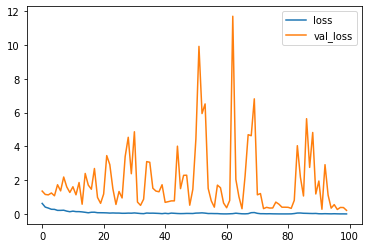

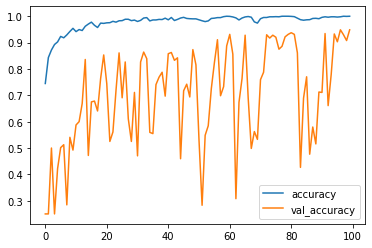

In [20]:
S_basemodel_None_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + S_model_name_None + '/' + S_model_name_None + '_loss,val_loss.png')
S_basemodel_None_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + S_model_name_None + '/' + S_model_name_None + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(S_basemodel_None_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(S_basemodel_None_df['val_accuracy'].max()))

In [21]:
print("Evaluate on test data")
S_basemodel_None_results = S_basemodel_None.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", S_basemodel_None_results)

Evaluate on test data
20/20 [==============================] - 3s 32ms/step - loss: 0.2416 - accuracy: 0.9438
test loss, test acc: [0.2416381537914276, 0.9437500238418579]


In [22]:
S_basemodel_None_pred_Y = S_basemodel_None.predict(xTest_S, verbose = True)

20/20 [==============================] - 3s 30ms/step


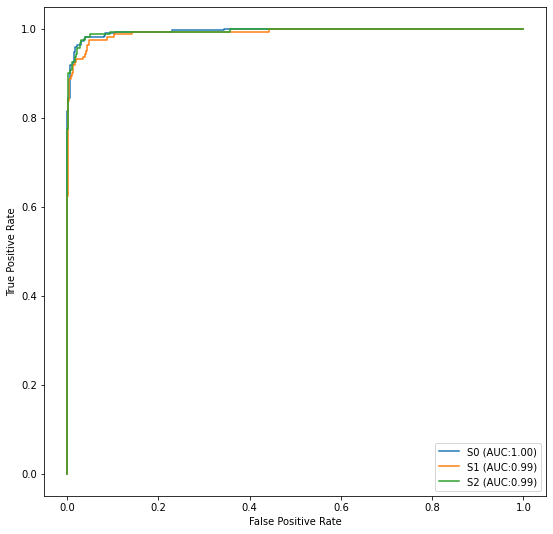

In [23]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(S_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_S[:,idx].astype(int), S_basemodel_None_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + S_model_name_None + '/' + S_model_name_None +'_TESTSET_AUC.png' )

## 3-3. Source Domain Training - weights='imagenet'

In [24]:
S_basemodel_imagenet=model_imagenet()
#S_basemodel_None.summary()

29097984/29084464 [==============================] - 0s 0us/step


In [25]:
S_basemodel_imagenet.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=imagenet_patience_num, restore_best_weights=True)

S_basemodel_imagenet_main =S_basemodel_imagenet.fit(xTrain_S, yTrain_S, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_S, yValid_S), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(S_basemodel_imagenet_main.history["val_accuracy"]) * 100))

Epoch 1/100
30/30 [==============================] - 20s 237ms/step - loss: 0.3644 - accuracy: 0.8615 - val_loss: 3.5792 - val_accuracy: 0.6625
Epoch 2/100
30/30 [==============================] - 5s 151ms/step - loss: 0.1133 - accuracy: 0.9620 - val_loss: 3.4398 - val_accuracy: 0.6047
Epoch 3/100
30/30 [==============================] - 5s 151ms/step - loss: 0.0430 - accuracy: 0.9859 - val_loss: 1.8983 - val_accuracy: 0.6547
Epoch 4/100
30/30 [==============================] - 5s 157ms/step - loss: 0.0606 - accuracy: 0.9766 - val_loss: 1.7542 - val_accuracy: 0.7563
Epoch 5/100
30/30 [==============================] - 5s 157ms/step - loss: 0.0801 - accuracy: 0.9724 - val_loss: 2.0242 - val_accuracy: 0.7797
Epoch 6/100
30/30 [==============================] - 5s 156ms/step - loss: 0.0198 - accuracy: 0.9943 - val_loss: 0.4708 - val_accuracy: 0.9219
Epoch 7/100
30/30 [==============================] - 5s 151ms/step - loss: 0.0126 - accuracy: 0.9974 - val_loss: 0.6239 - val_accuracy: 0.885

In [26]:
S_basemodel_imagenet_df = pd.DataFrame(S_basemodel_imagenet_main.history)
S_basemodel_imagenet_df.to_csv( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_df.csv' )
S_basemodel_imagenet_df

,loss,accuracy,val_loss,val_accuracy
0,0.364351,0.861458,3.579230,0.662500
1,0.113282,0.961979,3.439834,0.604688
2,0.043027,0.985937,1.898333,0.654688
3,0.060599,0.976562,1.754210,0.756250
4,0.080127,0.972396,2.024214,0.779688
5,0.019814,0.994271,0.470775,0.921875
6,0.012563,0.997396,0.623861,0.885938
7,0.034743,0.990104,1.830633,0.698438
8,0.014419,0.995833,0.242137,0.935938
9,0.005292,0.998958,0.347154,0.931250


Minimum validation loss: 0.04144192487001419
Maximum validation accuracy: 0.987500011920929


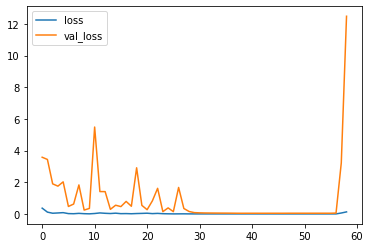

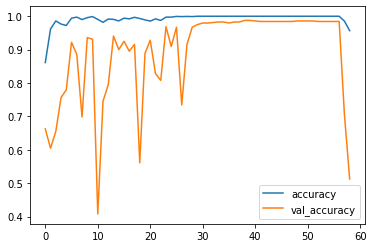

In [27]:
S_basemodel_imagenet_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_loss,val_loss.png')
S_basemodel_imagenet_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(S_basemodel_imagenet_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(S_basemodel_imagenet_df['val_accuracy'].max()))

In [28]:
print("Evaluate on test data")
S_model_name_imagenet_results = S_basemodel_imagenet.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", S_model_name_imagenet_results)

Evaluate on test data
20/20 [==============================] - 3s 32ms/step - loss: 0.0228 - accuracy: 0.9922
test loss, test acc: [0.022783061489462852, 0.9921875]


In [29]:
S_model_name_imagenet_pred_Y = S_basemodel_imagenet.predict(xTest_S, verbose = True)

20/20 [==============================] - 3s 30ms/step


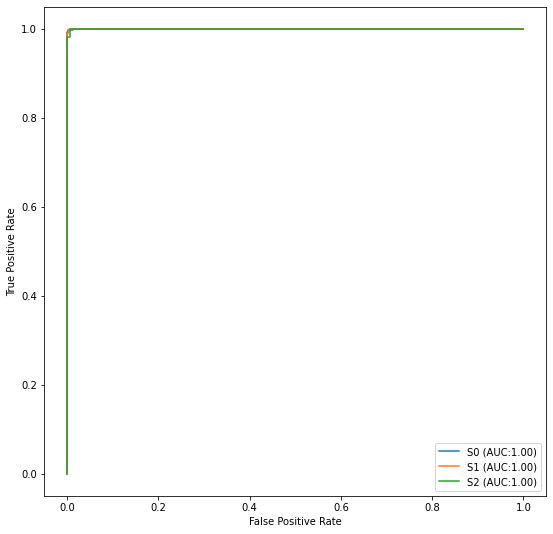

In [30]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(S_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_S[:,idx].astype(int), S_model_name_imagenet_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet +'_TESTSET_AUC.png' )

## 3-4. Target Domain Training - weights=None

In [31]:
T_basemodel_None=model_None()
#S_basemodel_None.summary()

In [32]:
T_basemodel_None.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=None_patience_num, restore_best_weights=True)

T_basemodel_None_main =T_basemodel_None.fit(xTrain_T, yTrain_T, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_T, yValid_T), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(T_basemodel_None_main.history["val_accuracy"]) * 100))

Epoch 1/100
23/23 [==============================] - 19s 286ms/step - loss: 0.4500 - accuracy: 0.8271 - val_loss: 1.1828 - val_accuracy: 0.2917
Epoch 2/100
23/23 [==============================] - 4s 157ms/step - loss: 0.1477 - accuracy: 0.9479 - val_loss: 2.1321 - val_accuracy: 0.2646
Epoch 3/100
23/23 [==============================] - 4s 165ms/step - loss: 0.1346 - accuracy: 0.9569 - val_loss: 3.2484 - val_accuracy: 0.3104
Epoch 4/100
23/23 [==============================] - 4s 157ms/step - loss: 0.0807 - accuracy: 0.9729 - val_loss: 9.4502 - val_accuracy: 0.2542
Epoch 5/100
23/23 [==============================] - 4s 157ms/step - loss: 0.1140 - accuracy: 0.9590 - val_loss: 11.0123 - val_accuracy: 0.2500
Epoch 6/100
23/23 [==============================] - 4s 156ms/step - loss: 0.0984 - accuracy: 0.9715 - val_loss: 11.3533 - val_accuracy: 0.2542
Epoch 7/100
23/23 [==============================] - 4s 157ms/step - loss: 0.0776 - accuracy: 0.9729 - val_loss: 10.8265 - val_accuracy: 0.

In [33]:
T_basemodel_None_df = pd.DataFrame(T_basemodel_None_main.history)
T_basemodel_None_df.to_csv( path_model_result + T_model_name_None + '/' + T_model_name_None + '_df.csv' )
T_basemodel_None_df

,loss,accuracy,val_loss,val_accuracy
0,0.449984,0.827083,1.182767,0.291667
1,0.147716,0.947917,2.132081,0.264583
2,0.134562,0.956944,3.248410,0.310417
3,0.080657,0.972917,9.450210,0.254167
4,0.114027,0.959028,11.012258,0.250000
...,...,...,...,...
58,0.003216,0.998611,0.204490,0.956250
59,0.001705,1.000000,0.088432,0.972917
60,0.016052,0.992361,0.238359,0.947917
61,0.009958,0.997222,1.792917,0.679167


Minimum validation loss: 0.08381080627441406
Maximum validation accuracy: 0.9750000238418579


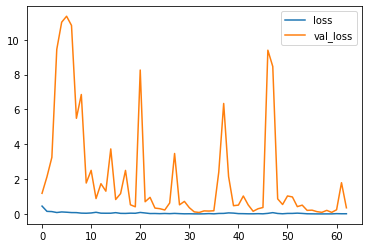

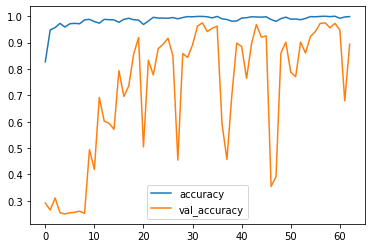

In [34]:
T_basemodel_None_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + T_model_name_None + '/' + T_model_name_None + '_loss,val_loss.png')
T_basemodel_None_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + T_model_name_None + '/' + T_model_name_None + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(T_basemodel_None_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(T_basemodel_None_df['val_accuracy'].max()))

In [35]:
print("Evaluate on test data")
T_basemodel_None_results = T_basemodel_None.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", T_basemodel_None_results)

Evaluate on test data
15/15 [==============================] - 3s 31ms/step - loss: 0.0557 - accuracy: 0.9875
test loss, test acc: [0.055678579956293106, 0.987500011920929]


In [36]:
T_basemodel_None_pred_Y = T_basemodel_None.predict(xTest_T, verbose = True)

15/15 [==============================] - 2s 31ms/step


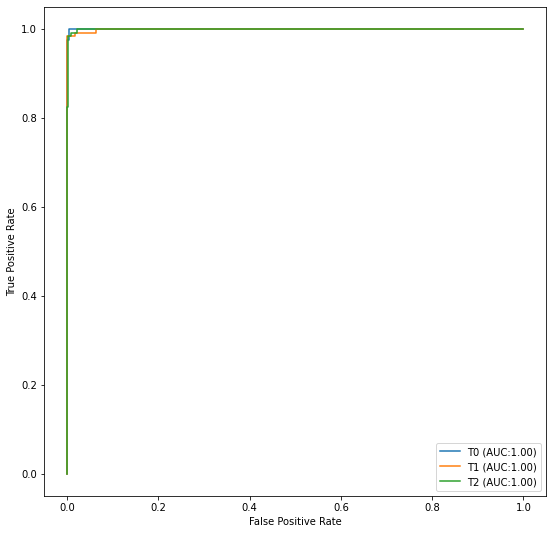

In [37]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(T_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_T[:,idx].astype(int), T_basemodel_None_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + T_model_name_None + '/' + T_model_name_None + '_TESTSET_AUC.png' )

## 3-5. Target Domain Training - weights='imagenet'

In [38]:
T_basemodel_imagenet=model_imagenet()
#S_basemodel_None.summary()

In [39]:
T_basemodel_imagenet.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=imagenet_patience_num, restore_best_weights=True)

T_basemodel_imagenet_main =T_basemodel_imagenet.fit(xTrain_T, yTrain_T, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_T, yValid_T), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(T_basemodel_imagenet_main.history["val_accuracy"]) * 100))

Epoch 1/100
23/23 [==============================] - 19s 270ms/step - loss: 0.2562 - accuracy: 0.9146 - val_loss: 1.5846 - val_accuracy: 0.6396
Epoch 2/100
23/23 [==============================] - 4s 157ms/step - loss: 0.0632 - accuracy: 0.9812 - val_loss: 9.7045 - val_accuracy: 0.5104
Epoch 3/100
23/23 [==============================] - 4s 165ms/step - loss: 0.0300 - accuracy: 0.9944 - val_loss: 2.8620 - val_accuracy: 0.6667
Epoch 4/100
23/23 [==============================] - 4s 165ms/step - loss: 0.0133 - accuracy: 0.9951 - val_loss: 1.9036 - val_accuracy: 0.7167
Epoch 5/100
23/23 [==============================] - 4s 165ms/step - loss: 0.0408 - accuracy: 0.9875 - val_loss: 0.4588 - val_accuracy: 0.8750
Epoch 6/100
23/23 [==============================] - 4s 158ms/step - loss: 0.0295 - accuracy: 0.9931 - val_loss: 1.1137 - val_accuracy: 0.8146
Epoch 7/100
23/23 [==============================] - 4s 155ms/step - loss: 0.0141 - accuracy: 0.9965 - val_loss: 1.8241 - val_accuracy: 0.779

In [40]:
T_basemodel_imagenet_df = pd.DataFrame(T_basemodel_imagenet_main.history)
T_basemodel_imagenet_df.to_csv( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_df.csv' )
T_basemodel_imagenet_df

,loss,accuracy,val_loss,val_accuracy
0,0.256244,0.914583,1.584606,0.639583
1,0.063226,0.981250,9.704467,0.510417
2,0.029974,0.994444,2.862015,0.666667
3,0.013328,0.995139,1.903588,0.716667
4,0.040765,0.987500,0.458799,0.875000
5,0.029467,0.993056,1.113740,0.814583
6,0.014112,0.996528,1.824132,0.779167
7,0.030189,0.990972,3.224576,0.716667
8,0.036706,0.985417,2.484262,0.756250
9,0.020017,0.995139,0.146398,0.972917


Minimum validation loss: 0.000504331081174314
Maximum validation accuracy: 1.0


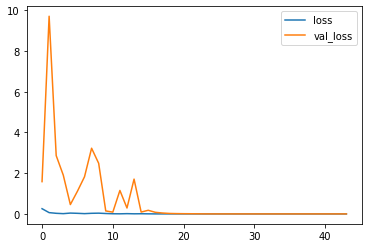

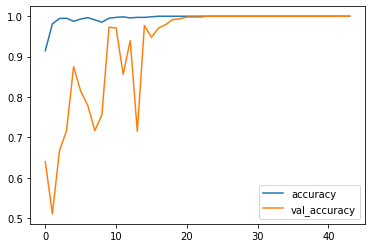

In [41]:
T_basemodel_imagenet_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_loss,val_loss.png')
T_basemodel_imagenet_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(T_basemodel_imagenet_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(T_basemodel_imagenet_df['val_accuracy'].max()))

In [42]:
print("Evaluate on test data")
T_model_name_imagenet_results = T_basemodel_imagenet.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", T_model_name_imagenet_results)

Evaluate on test data
15/15 [==============================] - 2s 32ms/step - loss: 0.0106 - accuracy: 0.9979
test loss, test acc: [0.01064453087747097, 0.9979166388511658]


In [43]:
T_model_name_imagenet_pred_Y = T_basemodel_imagenet.predict(xTest_T, verbose = True)

15/15 [==============================] - 2s 30ms/step


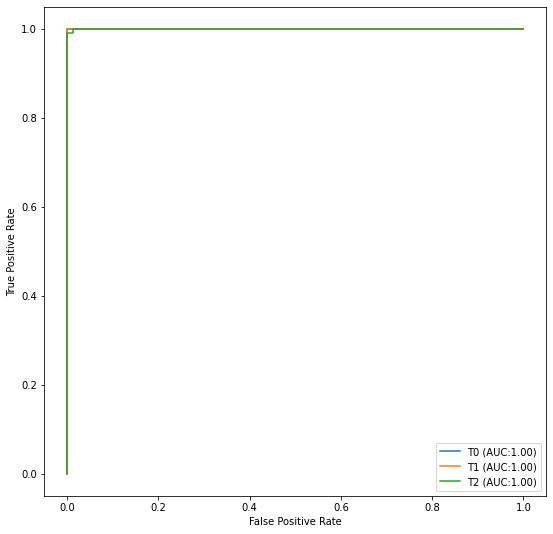

In [44]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(T_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_T[:,idx].astype(int), T_model_name_imagenet_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_TESTSET_AUC.png' )

# 4. Result Report

In [45]:
print(S_model_name_None)
print("test loss, test acc:", S_basemodel_None_results)

S_DenseNet121_None
test loss, test acc: [0.2416381537914276, 0.9437500238418579]


In [46]:
print(S_model_name_imagenet)
print("test loss, test acc:", S_model_name_imagenet_results)

S_DenseNet121_imagenet
test loss, test acc: [0.022783061489462852, 0.9921875]


In [47]:
print(T_model_name_None)
print("test loss, test acc:", T_basemodel_None_results)

T_DenseNet121_None
test loss, test acc: [0.055678579956293106, 0.987500011920929]


In [48]:
print(T_model_name_imagenet)
print("test loss, test acc:", T_model_name_imagenet_results)

T_DenseNet121_imagenet
test loss, test acc: [0.01064453087747097, 0.9979166388511658]


# 5. Source Domain Training Model ↔ Target Domain Training Model 상호 Test Data Set 평가 

In [49]:
print( S_model_name_None + " →→→ Target Test")
S_basemodel_None_results_T = S_basemodel_None.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", S_basemodel_None_results_T)

S_DenseNet121_None →→→ Target Test
15/15 [==============================] - 0s 32ms/step - loss: 5.5588 - accuracy: 0.3958
test loss, test acc: [5.558762550354004, 0.3958333432674408]


In [50]:
print( S_model_name_imagenet + " →→→ Target Test")
S_model_name_imagenet_results_T = S_basemodel_imagenet.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", S_model_name_imagenet_results_T)

S_DenseNet121_imagenet →→→ Target Test
15/15 [==============================] - 0s 32ms/step - loss: 4.3111 - accuracy: 0.5688
test loss, test acc: [4.311081886291504, 0.5687500238418579]


In [51]:
print( T_model_name_None + " →→→ Source Test")
T_basemodel_None_results_S = T_basemodel_None.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", T_basemodel_None_results_S)

T_DenseNet121_None →→→ Source Test
20/20 [==============================] - 1s 33ms/step - loss: 4.9473 - accuracy: 0.4531
test loss, test acc: [4.947305202484131, 0.453125]


In [52]:
print( T_model_name_imagenet + " →→→ Source Test")
T_model_name_imagenet_results_S = T_basemodel_imagenet.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", T_model_name_imagenet_results_S)

T_DenseNet121_imagenet →→→ Source Test
20/20 [==============================] - 1s 33ms/step - loss: 3.2584 - accuracy: 0.4141
test loss, test acc: [3.258441209793091, 0.4140625]


# 6. Model Save 

In [53]:
S_basemodel_None.save( path_model_result + S_model_name_None + '/' + S_model_name_None + '.h5' )
S_basemodel_imagenet.save( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '.h5' )
T_basemodel_None.save( path_model_result + T_model_name_None + '/' + T_model_name_None + '.h5' )
T_basemodel_imagenet.save( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '.h5' )